In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# User inputs
file_dir  = '/Users/rmueller/Documents/UBC/MIDOSS/Data/DeptOfEcology/'
file_name = 'MuellerTrans4-30-20.xlsx'

In [3]:
# Import columns are: (E) 'StartDateTime, (G) Deliverer, (H) Receiver, (N) City, (P) Product, (Q) Quantity in Gallons, (R) Transfer Type (Fueling, Cargo, or Other)'
df = pd.read_excel(f'{file_dir}{file_name}',sheet_name='Vessel Oil Transfer', 
                   usecols="E,G,H,N,P,Q,R")

### Extract data for oil cargo transferred to vessels for marine export approximation

In [4]:
# Get all cargo fuel transfers
bool_cargo = df['TransferType']=='Cargo'
cargo_data = df[bool_cargo]

In [5]:
oil_traffic = {}
oil_traffic['destination']={}

for reciever in cargo_data.Receiver:
    # create a list of all recieving entities
    if reciever not in oil_traffic['destination']:
        oil_traffic['destination'][f'{reciever}'] = 0
    # create a list of all refinery destinations
    #if receiver.str.contains('Refinery')
#oil_traffic['destination']

### Evaluate marine oil export

#### By vessel type (This is the right way though I still need to remove Vancouver, WA)

In [6]:
# define list of strings that can be used to tag names for WA state refineries and terminals
# still in verification phase around accurately selecting Salish Sea marine terminals.  
# Check to see if Vancouver terminals are included in "export cargo" dataframe
oil_traffic['refinery_tags'] = ['Refinery', 'Refining']
oil_traffic['terminal_tags']  = ['Terminal', 'Petroleum', 'Inc', 'LLC', 'Ballard Oil Co.', 'Reisner Distributor, Inc.','NASWI']

In [18]:
# create dataset of export cargo in which export cargo is defined as
# all cargo being deliverd from (land-based) marine terminal
cargo_export = cargo_data[cargo_data.Deliverer.str.contains(oil_traffic['refinery_tags'][0])]
cargo_export = cargo_export.append(cargo_data[cargo_data.Deliverer.str.contains(oil_traffic['refinery_tags'][1])])

# # add oil from refinery locations
# for refinery_origin in oil_traffic['refinery_tags']:
#     display(refinery_origin)
#     export_cargo = export_cargo.append(
#         cargo_data.Deliverer.str.contains(f'{refinery_origin}')
#     )
    
# add oil from terminal locations
for terminal_origin in oil_traffic['terminal_tags']:
    display(terminal_origin)
    cargo_export = cargo_export.append(
        cargo_data[cargo_data.Deliverer.str.contains(f'{terminal_origin}')]
    )
    
# need to re-set indexing in order to use row-index as data_frame index
cargo_export.reset_index(drop=True, inplace=True)    

'Terminal'

'Petroleum'

'Inc'

'LLC'

'Ballard Oil Co.'

'Reisner Distributor, Inc.'

'NASWI'

In [25]:
test = {}
test['test'] = []
test['test'].append('test')
test['test'].append('test')
test['test']

['test', 'test']

In [57]:
# introduce dictionary for cargo traffic
oil_traffic['cargo'] = {}
# introduce dictionary entries for fuel volume export
oil_traffic['cargo']['atb_volume_export_total']    = 0
oil_traffic['cargo']['barge_volume_export_total']  = 0
oil_traffic['cargo']['tanker_volume_export_total'] = 0
oil_traffic['cargo']['atb_volume_export']    = []
oil_traffic['cargo']['barge_volume_export']  = []
oil_traffic['cargo']['tanker_volume_export'] = []
oil_traffic['cargo']['total']                = []
# add dictionary entries for fuel type
oil_traffic['cargo']['atb_oil_type']    = []
oil_traffic['cargo']['barge_oil_type']  = []
oil_traffic['cargo']['tanker_oil_type'] = []

# identify ship traffic 
[nrows,ncols] = cargo_export.shape
# total up volume of oil transferred onto ATB BARGES, non-ATB barges, and other vessels

# create counter for vessel-type
atb_counter = 0
barge_counter = 0
tanker_counter = 0
for rows in range(nrows):
    if 'ATB' in cargo_export.Receiver[rows]: 
        oil_traffic['cargo']['atb_volume_export_total'] = oil_traffic['cargo']['atb_volume_export_total'] + cargo_export.TransferQtyInGallon[rows]
        oil_traffic['cargo']['atb_volume_export'].append(cargo_export.TransferQtyInGallon[rows])
        oil_traffic['cargo']['atb_oil_type'].append(cargo_export.Product[rows])
        atb_counter += 1
    elif ('BARGE' in cargo_export.Receiver[rows] or \
        'Barge' in cargo_export.Receiver[rows] or \
        'PB' in cargo_export.Receiver[rows] or \
        'YON' in cargo_export.Receiver[rows] or \
        'DLB' in cargo_export.Receiver[rows]): 
        oil_traffic['cargo']['barge_volume_export_total'] = oil_traffic['cargo']['barge_volume_export_total'] + cargo_export.TransferQtyInGallon[rows] 
        oil_traffic['cargo']['barge_volume_export'].append(cargo_export.TransferQtyInGallon[rows])
        oil_traffic['cargo']['barge_oil_type'].append(cargo_export.Product[rows])
        barge_counter += 1
        #display(cargo_data.Receiver[rows])
    else:
        oil_traffic['cargo']['tanker_volume_export_total'] = oil_traffic['cargo']['tanker_volume_export_total'] + cargo_export.TransferQtyInGallon[rows] 
        oil_traffic['cargo']['tanker_volume_export'].append(cargo_export.TransferQtyInGallon[rows])
        oil_traffic['cargo']['tanker_oil_type'].append(cargo_export.Product[rows])
        tanker_counter += 1
        #display(cargo_data.Receiver[rows])

oil_traffic['cargo']['total'] = oil_traffic['cargo']['atb_volume_export_total'] + oil_traffic['cargo']['barge_volume_export_total'] + oil_traffic['cargo']['tanker_volume_export_total'] 

In [61]:
# Calculate percent of total transport by vessel type
atb_percent = 100*oil_traffic['cargo']['atb_volume_export_total']/oil_traffic['cargo']['total']
barge_percent = 100*oil_traffic['cargo']['barge_volume_export_total']/oil_traffic['cargo']['total']
tanker_percent = 100*oil_traffic['cargo']['tanker_volume_export_total']/oil_traffic['cargo']['total']
print(atb_percent)
print(barge_percent)
print(tanker_percent)

26.0362863004
2.06598242758
71.897731272


Text(0.5,1,'Types of vessels by volume receiving oil as cargo from land-based platform identified as terminal or refinery')

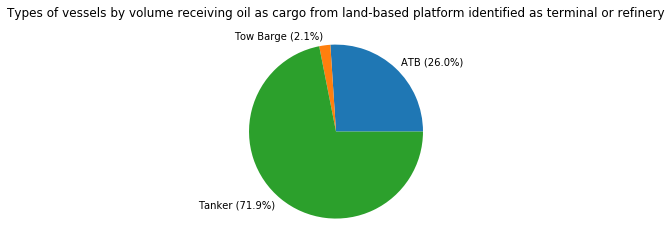

In [63]:
volume_export_byvessel = [oil_traffic['cargo']['atb_volume_export_total'], oil_traffic['cargo']['barge_volume_export_total'], oil_traffic['cargo']['tanker_volume_export_total']]
#colors = ['b', 'g', 'r', 'c', 'm', 'y']
labels = [f'ATB ({atb_percent:3.1f}%)', f'Tow Barge ({barge_percent:3.1f}%)',f'Tanker ({tanker_percent:3.1f}%)']
plt.gca().axis("equal")
plt.pie(volume_export_byvessel, labels= labels)
plt.title('Types of vessels by volume receiving oil as cargo from land-based platform identified as terminal or refinery')

#### By oil type within vessel type classification

In [68]:
len(oil_traffic['cargo']['atb_volume_export'])

459

In [86]:
oil_traffic['cargo']['atb']={}
oil_traffic['cargo']['atb']['CRUDE']=0
oil_traffic['cargo']['atb']['GASOLINE']=0
oil_traffic['cargo']['atb']['JET FUEL/KEROSENE']=0
oil_traffic['cargo']['atb']['DIESEL/MARINE GAS OIL']=0
oil_traffic['cargo']['atb']['DIESEL LOW SULPHUR (ULSD)']=0
oil_traffic['cargo']['atb']['BUNKER OIL/HFO']=0
oil_traffic['cargo']['atb']['other']=0

oil_traffic['cargo']['barge']={}
oil_traffic['cargo']['barge']['CRUDE']=0
oil_traffic['cargo']['barge']['GASOLINE']=0
oil_traffic['cargo']['barge']['JET FUEL/KEROSENE']=0
oil_traffic['cargo']['barge']['DIESEL/MARINE GAS OIL']=0
oil_traffic['cargo']['barge']['DIESEL LOW SULPHUR (ULSD)']=0
oil_traffic['cargo']['barge']['BUNKER OIL/HFO']=0
oil_traffic['cargo']['barge']['other']=0

oil_traffic['cargo']['tanker']={}
oil_traffic['cargo']['tanker']['CRUDE']=0
oil_traffic['cargo']['tanker']['GASOLINE']=0
oil_traffic['cargo']['tanker']['JET FUEL/KEROSENE']=0
oil_traffic['cargo']['tanker']['DIESEL/MARINE GAS OIL']=0
oil_traffic['cargo']['tanker']['DIESEL LOW SULPHUR (ULSD)']=0
oil_traffic['cargo']['tanker']['BUNKER OIL/HFO']=0
oil_traffic['cargo']['tanker']['other']=0
#oil_types = ['crude','gas','jet','diesel','ulsd','bunker','other']

oil_types = ['CRUDE', 'GASOLINE', 'JET FUEL/KEROSENE','DIESEL/MARINE GAS OIL', 
             'DIESEL LOW SULPHUR (ULSD)', 'BUNKER OIL/HFO', 'other']
#gas_export_data    = cargo_data[cargo_data['Product']=='GASOLINE']
#gas_export_total   = gas_export_data['TransferQtyInGallon'].sum()
#gas_export_percent = 100*gas_export_total/cargo_data.TransferQtyInGallon.sum()

#oil_traffic['cargo']['atb_volume_export'] = oil_traffic['cargo']['atb_volume_export'] + cargo_export.TransferQtyInGallon[rows]
#oil_traffic['cargo']['atb_oil_type'].append(cargo_export.Product[rows])
for oil_name in range(len(oil_types)):
    for rows in range(len(oil_traffic['cargo']['atb_volume_export'])):  
        if oil_types[oil_name] in oil_traffic['cargo']['atb_oil_type'][rows]: 
            oil_traffic['cargo']['atb'][oil_types[oil_name]] += oil_traffic['cargo']['atb_volume_export'][rows]
    for rows in range(len(oil_traffic['cargo']['barge_volume_export'])):  
        if oil_types[oil_name] in oil_traffic['cargo']['barge_oil_type'][rows]: 
            oil_traffic['cargo']['barge'][oil_types[oil_name]] += oil_traffic['cargo']['barge_volume_export'][rows]
    for rows in range(len(oil_traffic['cargo']['tanker_volume_export'])):  
        if oil_types[oil_name] in oil_traffic['cargo']['tanker_oil_type'][rows]: 
            oil_traffic['cargo']['tanker'][oil_types[oil_name]] += oil_traffic['cargo']['tanker_volume_export'][rows]
                  

In [89]:
oil_types

['CRUDE',
 'GASOLINE',
 'JET FUEL/KEROSENE',
 'DIESEL/MARINE GAS OIL',
 'DIESEL LOW SULPHUR (ULSD)',
 'BUNKER OIL/HFO',
 'other']

#### Plot up ATB fuel types

Text(0.5,1,'Types of oil transport by volume for ATBs from WA refineries and terminals')

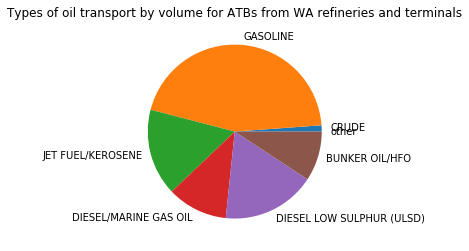

In [95]:
atb_volume_export = [oil_traffic['cargo']['atb']['CRUDE'],
                    oil_traffic['cargo']['atb']['GASOLINE'],
                    oil_traffic['cargo']['atb']['JET FUEL/KEROSENE'],
                    oil_traffic['cargo']['atb']['DIESEL/MARINE GAS OIL'],
                    oil_traffic['cargo']['atb']['DIESEL LOW SULPHUR (ULSD)'],
                    oil_traffic['cargo']['atb']['BUNKER OIL/HFO'],
                    oil_traffic['cargo']['atb']['other']]
#colors = ['b', 'g', 'r', 'c', 'm', 'y']
#labels = [f'ATB ({atb_percent:3.1f}%)', f'Tow Barge ({barge_percent:3.1f}%)',f'Tanker ({tanker_percent:3.1f}%)']
plt.gca().axis("equal")
plt.pie(atb_volume_export, labels= oil_types)
plt.title('Types of oil transport by volume for ATBs from WA refineries and terminals')

Text(0.5,1,'Types of oil transport by volume for barges from WA refineries and terminals')

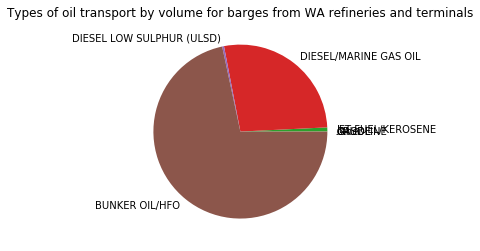

In [96]:
atb_volume_export = [oil_traffic['cargo']['barge']['CRUDE'],
                    oil_traffic['cargo']['barge']['GASOLINE'],
                    oil_traffic['cargo']['barge']['JET FUEL/KEROSENE'],
                    oil_traffic['cargo']['barge']['DIESEL/MARINE GAS OIL'],
                    oil_traffic['cargo']['barge']['DIESEL LOW SULPHUR (ULSD)'],
                    oil_traffic['cargo']['barge']['BUNKER OIL/HFO'],
                    oil_traffic['cargo']['barge']['other']]
#colors = ['b', 'g', 'r', 'c', 'm', 'y']
#labels = [f'ATB ({atb_percent:3.1f}%)', f'Tow Barge ({barge_percent:3.1f}%)',f'Tanker ({tanker_percent:3.1f}%)']
plt.gca().axis("equal")
plt.pie(atb_volume_export, labels= oil_types)
plt.title('Types of oil transport by volume for barges from WA refineries and terminals')

Text(0.5,1,'Types of oil transport by volume for tankers from WA refineries and terminals')

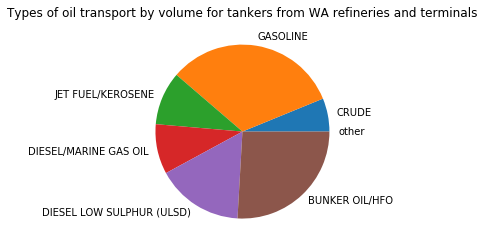

In [97]:
atb_volume_export = [oil_traffic['cargo']['tanker']['CRUDE'],
                    oil_traffic['cargo']['tanker']['GASOLINE'],
                    oil_traffic['cargo']['tanker']['JET FUEL/KEROSENE'],
                    oil_traffic['cargo']['tanker']['DIESEL/MARINE GAS OIL'],
                    oil_traffic['cargo']['tanker']['DIESEL LOW SULPHUR (ULSD)'],
                    oil_traffic['cargo']['tanker']['BUNKER OIL/HFO'],
                    oil_traffic['cargo']['tanker']['other']]
#colors = ['b', 'g', 'r', 'c', 'm', 'y']
#labels = [f'ATB ({atb_percent:3.1f}%)', f'Tow Barge ({barge_percent:3.1f}%)',f'Tanker ({tanker_percent:3.1f}%)']
plt.gca().axis("equal")
plt.pie(atb_volume_export, labels= oil_types)
plt.title('Types of oil transport by volume for tankers from WA refineries and terminals')

In [39]:
oil_traffic['cargo']['atb_volume_export']

1131912600

#### This is the wrong way (includes ship-to-ship transfers)

In [11]:
# # remove cargo fuel transfers to land-based entity in order to isolate export cargo
# oil_traffic['cargo'] = {}
# cargo_data = cargo_data[~cargo_data.Receiver.str.contains('Refinery')]
# cargo_data = cargo_data[~cargo_data.Receiver.str.contains('Refining')] # this is specifically for U.S. Oil in Tacoma
# cargo_data = cargo_data[~cargo_data.Receiver.str.contains('Terminal')]
# cargo_data = cargo_data[~cargo_data.Receiver.str.contains('Petroleum')] # This is for smaller outfits, like Ranier Petroleum or Maxum Petrolem
# cargo_data = cargo_data[~cargo_data.Receiver.str.contains('Inc')] # Covich, Petrocard
# cargo_data = cargo_data[~cargo_data.Receiver.str.contains('LLC')] # Pacific Functional Fluids, LLC; Coleman Oil Company, LLC
# cargo_data = cargo_data[~cargo_data.Receiver.str.contains('Ballard Oil Co.')]
# cargo_data = cargo_data[~cargo_data.Receiver.str.contains('Reisner Distributor, Inc.')]
# cargo_data = cargo_data[~cargo_data.Receiver.str.contains('NASWI')]

# # This dataset contains Columbia River locations that need to be scrubbed out
# cargo_data = cargo_data[~cargo_data.City.str.contains('vancouver')]

# # cargo_data is no longer indexed chronologically after removing 'Refinery', 'Terminal' and 'NASWI' entries
# # need to re-set indexing in order to use row-index as data_frame index
# cargo_data.reset_index(drop=True, inplace=True)
# [nrows,ncols] = cargo_data.shape

# # introduce dictionary entries for fuel volume export
# oil_traffic['cargo']['atb_volume_export']   = 0
# oil_traffic['cargo']['barge_volume_export'] = 0
# oil_traffic['cargo']['other_export'] = 0
# oil_traffic['cargo']['ship_to_ship'] = 0
# oil_traffic['cargo']['total']        = 0

# # carrier names
# oil_traffic['cargo']['atb_carrier']={}

# # total up volume of oil transferred onto ATB BARGES, non-ATB barges, and other vessels
# for rows in range(nrows):
#     # from land-based terminals and refineries only
#     if 'Refinery' in cargo_data.Deliverer[rows] or 'Refining' in cargo_data.Deliverer[rows] or 'Terminal' in cargo_data.Deliverer[rows]: 
#         if 'ATB' in cargo_data.Receiver[rows] :
#             oil_traffic['cargo']['atb_volume_export'] = oil_traffic['cargo']['atb_volume_export'] + cargo_data.TransferQtyInGallon[rows]
#             #display(cargo_data.Receiver[rows])
#             #if cargo_data.Receiver[rows] not in oil_traffic['cargo']['atb_carrier']:
#             #    oil_traffic['cargo']['atb_carrier'][f'{oil_traffic['cargo']['atb_carrier']}']=[f'{oil_traffic['cargo']['atb_carrier']}']
#         elif 'BARGE' in cargo_data.Receiver[rows] or 'Barge' in cargo_data.Receiver[rows] or 'PB' in cargo_data.Receiver[rows] or 'YON' in cargo_data.Receiver[rows] or 'DLB' in cargo_data.Receiver[rows]:  # and not 'ATB' in cargo_data.Receiver[rows]:  
#             oil_traffic['cargo']['barge_volume_export'] = oil_traffic['cargo']['barge_volume_export'] + cargo_data.TransferQtyInGallon[rows]
#             #display(cargo_data.Receiver[rows])
#         else:
#             oil_traffic['cargo']['other_export'] = oil_traffic['cargo']['other_export'] + cargo_data.TransferQtyInGallon[rows]
#             #display(cargo_data.Receiver[rows])
#     else:
#         oil_traffic['cargo']['ship_to_ship'] = oil_traffic['cargo']['ship_to_ship'] + cargo_data.TransferQtyInGallon[rows]
        
# oil_traffic['cargo']['total'] = oil_traffic['cargo']['atb_volume_export'] + oil_traffic['cargo']['barge_volume_export'] + oil_traffic['cargo']['other_export'] + oil_traffic['cargo']['ship_to_ship']
# oil_traffic['cargo']['total']/cargo_data.TransferQtyInGallon.sum()

### Add up volume transferred by fuel type 

In [15]:
# Add up the total volume of marine transport by product (this includes all transfers)
gas_export_data    = cargo_data[cargo_data['Product']=='GASOLINE']
gas_export_total   = gas_export_data['TransferQtyInGallon'].sum()
gas_export_percent = 100*gas_export_total/cargo_data.TransferQtyInGallon.sum()

diesel_export_data    = cargo_data[cargo_data['Product']=='DIESEL/MARINE GAS OIL']
diesel_export_total   = diesel_export_data['TransferQtyInGallon'].sum()
diesel_export_percent = 100*diesel_export_total/cargo_data.TransferQtyInGallon.sum()

bunker_export_data  = cargo_data[cargo_data['Product']=='BUNKER OIL/HFO']
bunker_export_total = bunker_export_data['TransferQtyInGallon'].sum()
bunker_export_percent = 100*bunker_export_total/cargo_data.TransferQtyInGallon.sum()

jet_export_data   = cargo_data[cargo_data['Product']=='JET FUEL/KEROSENE']
jet_export_total  = jet_export_data['TransferQtyInGallon'].sum()
jet_export_percent = 100*jet_export_total/cargo_data.TransferQtyInGallon.sum()

ulsd_export_data  = cargo_data[cargo_data['Product']=='DIESEL LOW SULPHUR (ULSD)']
ulsd_export_total = ulsd_export_data['TransferQtyInGallon'].sum()
ulsd_export_percent = 100*ulsd_export_total/cargo_data.TransferQtyInGallon.sum()


crude_export_data  = cargo_data[cargo_data['Product'].str.contains('CRUDE')]
crude_export_total = crude_export_data['TransferQtyInGallon'].sum()
crude_export_percent = 100*crude_export_total/cargo_data.TransferQtyInGallon.sum()

Other_fuel_total = cargo_data['TransferQtyInGallon'].sum() - crude_export_total - ulsd_export_total - jet_export_total - bunker_export_total - diesel_export_total - gas_export_total 
other_fuel_percent = 100*Other_fuel_total/cargo_data.TransferQtyInGallon.sum()

total_percent = other_fuel_percent+crude_export_percent+ulsd_export_percent+jet_export_percent+bunker_export_percent+diesel_export_percent+gas_export_percent
total_percent

100.0

### Plot up results

Text(0.5,1,'Marine Oil Export from WA Refineries and Terminals')

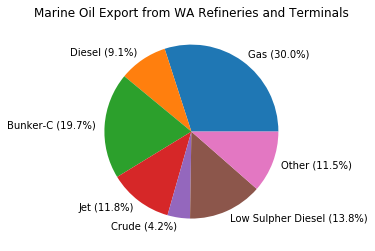

In [16]:
oil_export_values = [gas_export_total, diesel_export_total , bunker_export_total, jet_export_total, crude_export_total, ulsd_export_total, Other_fuel_total]
#colors = ['b', 'g', 'r', 'c', 'm', 'y']
labels = [f'Gas ({gas_export_percent:3.1f}%)', f'Diesel ({diesel_export_percent:3.1f}%)', f'Bunker-C ({bunker_export_percent:3.1f}%)', f'Jet ({jet_export_percent:3.1f}%)', f'Crude ({crude_export_percent:3.1f}%)', f'Low Sulpher Diesel ({ulsd_export_percent:3.1f}%)', f'Other ({other_fuel_percent:3.1f}%)']
plt.gca().axis("equal")
plt.pie(oil_export_values, labels= labels)
plt.title('Marine Oil Export from WA Refineries and Terminals')

In [17]:
cargo_data

,StartDateTime,Deliverer,Receiver,City,Product,TransferQtyInGallon,TransferType
0,2018-01-02 07:00:00,TLP Management Services LLC (TMS),GLOBAL PILOT,SEATTLE,DIESEL/MARINE GAS OIL,546000,Cargo
1,2018-01-02 07:00:00,Phillips 66 Ferndale Refinery,NATHAN SCHMIDT,FERNDALE,BUNKER OIL/HFO,1176000,Cargo
2,2018-01-02 01:00:00,Shell Puget Sound Refinery,ATB BARGE KIRBY 185-01,ANACORTES,BUNKER OIL/HFO,3150000,Cargo
3,2018-01-02 01:00:00,Shell Puget Sound Refinery,ATB BARGE KIRBY 185-01,ANACORTES,DIESEL/MARINE GAS OIL,3360000,Cargo
4,2018-01-03 02:00:00,Shell Puget Sound Refinery,CARTAGENA,ANACORTES,GASOLINE,7560000,Cargo
5,2018-01-01 00:01:00,Phillips 66 Ferndale Refinery,PROFESSOR KAREN ANN BROWN,FERNDALE,DIESEL/MARINE GAS OIL,399000,Cargo
6,2018-01-01 21:00:00,Phillips 66 Ferndale Refinery,ATB BARGE 550-2,FERNDALE,GASOLINE,3906000,Cargo
7,2018-01-02 12:00:00,Phillips 66 Ferndale Refinery,ATB BARGE FIGHT FANCONI ANEMIA,FERNDALE,GASOLINE,1890000,Cargo
8,2018-01-02 12:00:00,Phillips 66 Ferndale Refinery,ATB BARGE FIGHT FANCONI ANEMIA,FERNDALE,DIESEL/MARINE GAS OIL,1470000,Cargo
9,2018-01-02 08:00:00,Pacific Ethanol,NEW ENDEAVOR,"BOARDMAN, OR",ETHANOL,425040,Cargo
